## Outline

Based on the dataset, the choice of "Driver/sales workers and truck drivers" occupation was made due to their relative significant number of observations which is 3189. Study decided not to merge this category with other vehicle operator position since they are structurally different (ex. taxi and bus drivers usually operate within one county while truck drivers can move across states which drastically differ their lifestyle). 

Study created a variable wage = (Weekly Earnings)/(Weekly hours) or earnwke/uhours

Wage is then transformed into log(wage) variable to fit the regression requiremnets. The log-transformed wage distribution appears to be more suitable for OLS regression. 

Prior to the analysis, categorical variables are converted to numerical encoding to fit the models.

Out of 3189, 54 observetion where removed due to the extreme values which seems irelavant for understanding chosen occupation ( obs. like a single wage of $120 while the closest biggest value is 76 or wages below federal minimal level). 

The regression analysis starts with age as independent variable since it has the strongest correlation with the wage, what is explained in details in Regression section. 

* Section of Distributions showes useful insights of potential predictors.

* Section of Regressions consists of 4 models from simple to complex 

* Section of Model Performance Comparison compare models by RMSE in the full sample, cross-validated RMSE, and BIC in the full sample. 

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from plotnine import *

C:\Users\mailb\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_all = pd.read_csv("https://osf.io/download/4ay9x/")

data_all.columns

top_occ = data_all['occ2012'].value_counts().head(36)
print(top_occ)

occ2012
2310    3636
5700    3511
3255    3455
430     3352
4720    3327
4760    3226
9130    3189
4700    3057
4220    2464
5240    2329
3600    2224
4110    2178
4020    2147
9620    2015
800     1815
5620    1611
5000    1560
5400    1478
4230    1446
2200    1437
120     1401
6260    1388
1020    1335
4850    1333
2320    1323
5860    1320
10      1274
5120    1229
4610    1207
2540    1137
7750    1081
4250    1072
20      1047
50      1033
2100    1027
8965    1015
Name: count, dtype: int64


C:\Users\mailb\AppData\Local\Temp\ipykernel_39244\3611166618.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
data_all[data_all['occ2012']==9130].count()

Unnamed: 0    3189
hhid          3189
intmonth      3189
stfips        3189
weight        3189
earnwke       3189
uhours        3189
grade92       3189
race          3189
ethnic         527
age           3189
sex           3189
marital       3189
ownchild      3189
chldpres      3189
prcitshp      3189
state         3189
ind02         3189
occ2012       3189
class         3189
unionmme      3189
unioncov      2815
lfsr94        3189
dtype: int64

In [4]:
# Create a variable for Hourly Earnings

data_all["wage"] = data_all["earnwke"] / data_all["uhours"]
print(data_all[["earnwke", "uhours", "wage"]].head())

   earnwke  uhours       wage
0  1692.00      40  42.300000
1   450.00      40  11.250000
2  1090.00      60  18.166667
3   769.23      40  19.230750
4   826.92      40  20.673000


In [5]:
# Isolate category 9130 (Driver/sales workers and truck drivers)
data_9130 = data_all[data_all["occ2012"] == 9130].copy()

# Remove extreme wage values: keeping only wages between $5.15 (federal minimum wage for 2011 was $5.15) and 120
data_9130 = data_9130[(data_9130["wage"] > 5.15) & (data_9130["wage"] < 120)].copy()

# Verify the correctness and number of observations
print(data_9130["occ2012"].head())
print(f"Number of observations in category 9130: {data_9130.shape[0]}")

47     9130
51     9130
109    9130
139    9130
172    9130
Name: occ2012, dtype: int64
Number of observations in category 9130: 3150


## Distributions

In [6]:
# Get distribution statistics of 9130 category by wage
earnwke_distribution = data_9130["earnwke"].describe().reset_index()
earnwke_distribution.columns = ["Statistic", "Value"]

# Display the wage distribution
print(earnwke_distribution)

# Get distribution statistics of 9130 category by wage
uhours_distribution = data_9130["uhours"].describe().reset_index()
uhours_distribution.columns = ["Statistic", "Value"]

# Display the wage distribution
print(uhours_distribution)

  Statistic        Value
0     count  3150.000000
1      mean   804.870295
2       std   449.694716
3       min    25.000000
4       25%   500.000000
5       50%   720.000000
6       75%  1000.000000
7       max  2884.610000
  Statistic        Value
0     count  3150.000000
1      mean    43.788889
2       std    11.480064
3       min     2.000000
4       25%    40.000000
5       50%    40.000000
6       75%    50.000000
7       max    99.000000


In [7]:
# Get distribution statistics of 9130 category by wage
wage_9130_distribution = data_9130["wage"].describe().reset_index()
wage_9130_distribution.columns = ["Statistic", "Value"]

# Display the wage distribution
print(wage_9130_distribution)

  Statistic        Value
0     count  3150.000000
1      mean    18.083353
2       std     8.607804
3       min     5.333333
4       25%    12.240727
5       50%    16.250000
6       75%    21.666667
7       max    76.900000


In [8]:
# Compute the distribution of  by state
wage_distribution = data_9130["wage"].value_counts().reset_index()
wage_distribution.columns = ["Wage", "Count"]

# Sort the table for better readability
wage_distribution = wage_distribution.sort_values(by="Wage")

# Display the distribution
print(wage_distribution)

          Wage  Count
433   5.333333      1
283   5.500000      2
676   5.538400      1
835   5.625000      1
521   5.750000      1
..         ...    ...
348  57.692250      1
101  64.102444      5
836  67.300000      1
55   72.115250      8
605  76.900000      1

[1048 rows x 2 columns]


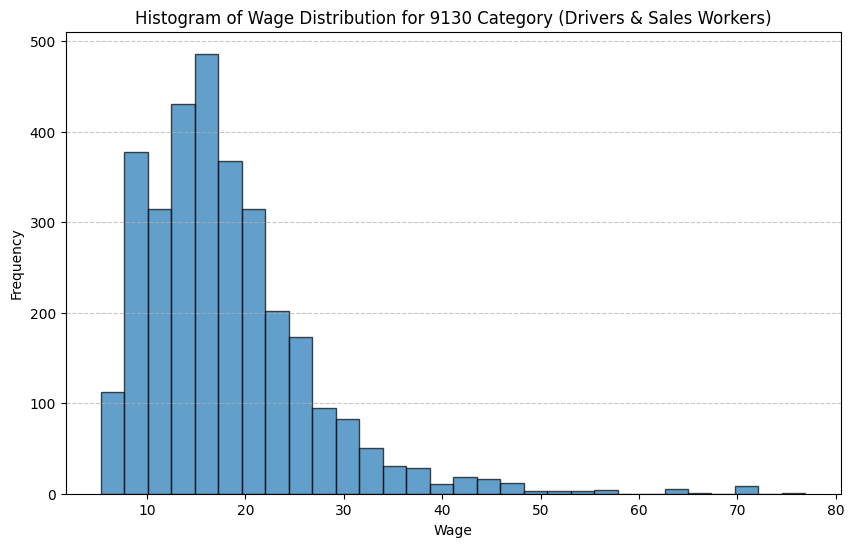

In [9]:
# Plot histogram of wage distribution
plt.figure(figsize=(10,6))
plt.hist(data_9130["wage"], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Wage")
plt.ylabel("Frequency")
plt.title("Histogram of Wage Distribution for 9130 Category (Drivers & Sales Workers)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Data adjusted further for extreme values shown on the histogram. 
The wage has continious diminishing trend before $60 and then only clusters after. 
It can be a sign of some very specific temporary contracts not common for the market. 

Thus, we remove in total **54 extreme values** to better fit for model construction.

In [10]:
# We adjusted data further for extreme values shown on the histogram. 
# The wage has continious diminishing trend before $60 and then only clusters after. 
# It can be a sign of some very specific temporary contracts not common for the market. 

#Thus, we remove in total 54 extreme values to better fit for model construction.
data_9130 = data_9130[(data_9130["wage"] > 5.15) & (data_9130["wage"] < 60)].copy()

# Get distribution statistics of 9130 category by wage without extremes
wage_9130_distribution = data_9130["wage"].describe().reset_index()
wage_9130_distribution.columns = ["Statistic", "Value"]

# Display the wage distribution
print(wage_9130_distribution)

  Statistic        Value
0     count  3135.000000
1      mean    17.837617
2       std     7.853712
3       min     5.333333
4       25%    12.222222
5       50%    16.183333
6       75%    21.623625
7       max    57.692250


In [11]:
# Compute the distribution of  by state
state_distribution = data_9130["state"].value_counts().reset_index()
state_distribution.columns = ["State", "Count"]

# Display the distribution
print(state_distribution)

   State  Count
0      5    296
1      4    246
2      9    222
3      3    209
4      8    206
..   ...    ...
64    57      7
65    RI      7
66    MA      4
67    53      4
68    88      3

[69 rows x 2 columns]


In [12]:
# Define Education Level Mapping based on grade92 measurement codes (31 to 46)
education_mapping = {
    31: "Less than 1st grade",
    32: "1st - 4th grade",
    33: "5th - 6th grade",
    34: "7th - 8th grade",
    35: "9th grade",
    36: "10th grade",
    37: "11th grade",
    38: "12th grade, no diploma",
    39: "High school graduate (diploma or GED)",
    40: "Some college, no degree",
    41: "Associate degree (vocational)",
    42: "Associate degree (academic)",
    43: "Bachelor's degree",
    44: "Master's degree",
    45: "Professional degree",
    46: "Doctorate degree"
}

# Filter grade92 values within the range 31 to 46
data_9130_filtered = data_9130[data_9130["grade92"].between(31, 46, inclusive="both")].copy()

# Convert 'grade92' column to numeric type
data_9130_filtered["grade92"] = pd.to_numeric(data_9130_filtered["grade92"], errors='coerce')

# Apply the mapping for better readability
data_9130_filtered["Education Level"] = data_9130_filtered["grade92"].map(education_mapping)

# Get distribution of grade92 (Education Level)
education_distribution = data_9130_filtered["Education Level"].value_counts().reset_index()
education_distribution.columns = ["Education Level", "Count"]

# Display the distribution
print(education_distribution)

                          Education Level  Count
0   High school graduate (diploma or GED)   1645
1                 Some college, no degree    636
2                       Bachelor's degree    157
3           Associate degree (vocational)    148
4                              11th grade    122
5             Associate degree (academic)    114
6                              10th grade     77
7                  12th grade, no diploma     69
8                               9th grade     54
9                         7th - 8th grade     40
10                        5th - 6th grade     39
11                        Master's degree     12
12                        1st - 4th grade      9
13                    Professional degree      5
14                       Doctorate degree      4
15                    Less than 1st grade      4


In [13]:
# Get distribution statistics of 9130 category by grade92 (Education Level)
grade92_distribution = data_9130["grade92"].describe().reset_index()
grade92_distribution.columns = ["Statistic", "Value"]

# Display the grade92 distribution
print(grade92_distribution)

  Statistic        Value
0     count  3135.000000
1      mean    39.233174
2       std     1.829224
3       min    31.000000
4       25%    39.000000
5       50%    39.000000
6       75%    40.000000
7       max    46.000000


   - 31 = Less than 1st grade  
   - 39 = High school graduate (diploma or GED)  
   - 40 = Some college, no degree  
   - 46 = Doctorate degree  

In [14]:
# Define Ethnicity Mapping based on the given codes
ethnicity_mapping = {
    1: "Mexican",
    2: "Puerto Rican",
    3: "Cuban",
    4: "Central/South American",
    5: "Other Spanish",
    6: "Not Hispanic"
}

# Ensure 'ethnic' column is numeric
data_9130["ethnic"] = pd.to_numeric(data_9130["ethnic"], errors='coerce')

# Apply the mapping for better readability
data_9130["Ethnicity"] = data_9130["ethnic"].map(ethnicity_mapping)

# Get distribution of ethnicities
ethnicity_distribution = data_9130["Ethnicity"].value_counts().reset_index()
ethnicity_distribution.columns = ["Ethnicity", "Count"]

# Display the distribution
print(ethnicity_distribution)

                Ethnicity  Count
0                 Mexican    321
1           Other Spanish     31
2            Not Hispanic     31
3                   Cuban     28
4            Puerto Rican     27
5  Central/South American     27


In [15]:
# Get distribution of 9130 category by age
age_distribution = data_9130["age"].describe().reset_index()
age_distribution.columns = ["Statistic", "Value"]

# Display the age distribution statistics
print(age_distribution)

  Statistic        Value
0     count  3135.000000
1      mean    43.908453
2       std    12.062176
3       min    16.000000
4       25%    35.000000
5       50%    45.000000
6       75%    54.000000
7       max    64.000000


In [16]:
# Define Sex Mapping
sex_mapping = {
    1: "Male",
    2: "Female"
}

# Ensure 'sex' column is numeric
data_9130["sex"] = pd.to_numeric(data_9130["sex"], errors='coerce')

# Apply the mapping for better readability
data_9130["Sex"] = data_9130["sex"].map(sex_mapping)

# Get distribution of sex in the 9130 category
sex_distribution = data_9130["Sex"].value_counts().reset_index()
sex_distribution.columns = ["Sex", "Count"]

# Display the distribution
print(sex_distribution)

      Sex  Count
0    Male   2965
1  Female    170


In [17]:
# Define Marital Status Mapping
marital_mapping = {
    1: "Married (civilian spouse present)",
    2: "Married (Armed Forces spouse present)",
    3: "Married (spouse absent)",
    4: "Widowed",
    5: "Divorced",
    6: "Separated",
    7: "Never Married"
}

# Ensure 'marital' column is numeric
data_9130["marital"] = pd.to_numeric(data_9130["marital"], errors='coerce')

# Apply the mapping for better readability
data_9130["Marital Status"] = data_9130["marital"].map(marital_mapping)

# Get distribution of marital status in the 9130 category
marital_distribution = data_9130["Marital Status"].value_counts().reset_index()
marital_distribution.columns = ["Marital Status", "Count"]

# Display the distribution
print(marital_distribution)

                          Marital Status  Count
0      Married (civilian spouse present)   1826
1                          Never Married    732
2                               Divorced    425
3                              Separated     64
4                Married (spouse absent)     53
5                                Widowed     34
6  Married (Armed Forces spouse present)      1


In [18]:
# Get distribution of number of own children (ownchild) in the 9130 category
ownchild_distribution = data_9130["ownchild"].value_counts().reset_index()
ownchild_distribution.columns = ["Number of Own Children", "Count"]

# Sort the table for better readability
ownchild_distribution = ownchild_distribution.sort_values(by="Number of Own Children")

# Display the distribution
print(ownchild_distribution)

   Number of Own Children  Count
0                       0   2113
1                       1    465
2                       2    349
3                       3    159
4                       4     37
5                       5      8
6                       6      3
7                       7      1


In [19]:
# Get distribution of industry classification (ind02) in the 9130 category
industry_distribution = data_9130["ind02"].value_counts().reset_index()
industry_distribution.columns = ["Industry Code (ind02)", "Count"]

# Sort the table for better readability
industry_distribution = industry_distribution.sort_values(by="Count")

# Display the distribution
print(industry_distribution)

                                 Industry Code (ind02)  Count
173                               Labor unions (81393)      1
148  Rubber products, except tires, manufacturing (...      1
147  Clothing and accessories, except shoe, stores ...      1
146                     Other personal services (8129)      1
145                 Specialized design services (5414)      1
..                                                 ...    ...
4      Waste management and remediation services (562)    147
3                        Couriers and messengers (492)    161
2                                 ** Construction (23)    177
1    Restaurants and other food services (722 exc. ...    189
0                           Truck transportation (484)   1045

[174 rows x 2 columns]


In [20]:
# Get distribution of class classification in the 9130 category
class_distribution = data_9130["class"].value_counts().reset_index()
class_distribution.columns = ["Class Code", "Count"]

# Sort the table for better readability
class_distribution = class_distribution.sort_values(by="Count")

# Display the distribution
print(class_distribution)

             Class Code  Count
4    Government - State     24
3    Private, Nonprofit     38
2  Government - Federal     39
1    Government - Local     84
0   Private, For Profit   2950


In [21]:
# Get distribution of union membership (unionmme) in the 9130 category
union_membership_distribution = data_9130["unionmme"].value_counts().reset_index()
union_membership_distribution.columns = ["Union Membership Code", "Count"]

# Sort the table for better readability
union_membership_distribution = union_membership_distribution.sort_values(by="Union Membership Code")

# Display the distribution
print(union_membership_distribution)

  Union Membership Code  Count
0                    No   2763
1                   Yes    372


In [22]:
# Get distribution of union coverage (unioncov) in the 9130 category
union_coverage_distribution = data_9130["unioncov"].value_counts().reset_index()
union_coverage_distribution.columns = ["Union Coverage Code", "Count"]

# Sort the table for better readability
union_coverage_distribution = union_coverage_distribution.sort_values(by="Union Coverage Code")

# Display the distribution
print(union_coverage_distribution)

  Union Coverage Code  Count
0                  No   2737
1                 Yes     26


In [23]:

# Get distribution of labor force status (lfsr94) in the 9130 category
labor_force_distribution = data_9130["lfsr94"].value_counts().reset_index()
labor_force_distribution.columns = ["Labor Force Status Code (lfsr94)", "Count"]

# Sort the table for better readability
labor_force_distribution = labor_force_distribution.sort_values(by="Labor Force Status Code (lfsr94)")

# Display the distribution
print(labor_force_distribution)

  Labor Force Status Code (lfsr94)  Count
1                  Employed-Absent     91
0                 Employed-At Work   3044


**Conclusions on distributions section to be considered**

(state) Relatively equal division of observations in 
Geographic Regional Residency 

(grade92) The Highest Educational level: 
52% - high school, 20% - some college etc. 

(ethnic) Ethnicity: 
~15% of observations declared Hispanic background. 

(age) Age has a wave shaped distribution from min 16 to max 64 years old. While mean age is 43.8, 25% is 35, 50% is 45, 75% is 54. 

(marital) According to the Marital Status, 58% of drivers are married, 24% never married, 13.5% divorced.

(ownchild) 67% of observed drivers have declared zero children, while the rest 33% have at least 1 while 50 (1.6%) declared more than 3 children per household. 

(ind02) 3184 observation have been assigned to 174 different industries. The biggest category of 33,5% declared occupation is in truck transportation while next biggest occupation is food service is about 6.3%.


Variables that lack variation: 
- (sex) 94.3% of all drivers are male . 
- (class) 94.1% of drivers are classified to private, for profit sector . 
- (unionmme) 88,3% of respondents declared no union membership . 
- (unioncov) Out of 11,7% those declared union membership, only 6.9% (26 observations) have union coverage . 
- (lfsr94) 97.0% are employed .

## Regressions

In [24]:
# Create a new variable for log-transformed wage
data_9130["log_wage"] = np.log(data_9130["wage"])
log_wage_9130 = data_9130["log_wage"]

# Display the summary statistics for log-transformed wage
print(log_wage_9130)

47        2.224624
51        2.783982
109       2.682062
139       3.052315
172       2.956503
            ...   
149191    3.091042
149246    3.065258
149260    2.956503
149300    2.979095
149309    2.995732
Name: log_wage, Length: 3135, dtype: float64


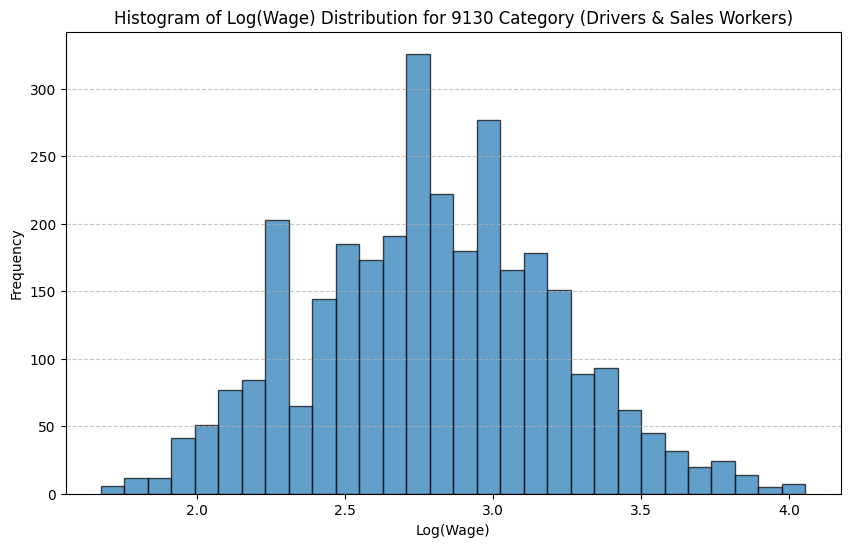

In [25]:
# Plot histogram of log-transformed wage distribution
plt.figure(figsize=(10,6))
plt.hist(log_wage_9130, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Log(Wage)")
plt.ylabel("Frequency")
plt.title("Histogram of Log(Wage) Distribution for 9130 Category (Drivers & Sales Workers)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**The log-transformed wage distribution:**

- The distribution appears approximately normal, centered around log(Wage) ≈ 2.5 - 3.0.
- The shape is much more symmetric compared to the original wage histogram, without extreme skewness or long tails,.
- The log-transformed wage distribution is suitable for OLS regression. We can proceed with regression analysis.

**Adjusting the data**

In [26]:
# Before any analysis, we convert categorical variables to numerical encoding to fit the models.
categorical_vars = ["ind02", "state", "grade92", "ethnic", "marital", "ownchild"]
for col in categorical_vars:
    data_9130[col] = data_9130[col].astype("category").cat.codes

**First pick models**
- model1 = "log_wage_9130 ~ ind02"

At first, wage distribution by industries looks promissing due to the big variety of industry distributions. However, the simple regression of log(wage) on industry shows 0.001 R^2. The plot of the regression clearly shows lack of correlation. 

**Choice of Age Variable**

Among presented variables many can support the explaination of the distribution in wage among drivers. 
The Age choice seems more natural since driving, especially trucks, relies on experience of the driver. Many firms would prefer experienced, but older driver then vise versa due to the safety and risk purposes. Drivers labor market lack the career growth, many rates are fixed and firms offer contract jobs that rely more on the specifics and duration of task rather then anything else. As third of correspondents declared working in truck transportation, many different factors like distance, contracts duration, type of cargo, type of truck etc. are the core creators of the salary. Also, some drivers can be self-employed; thus, their wage is based on contract, that can happend how many times a month and wage is potentially weak estimate for measuring earnings. Since similar logic is applicable to the correlation between industry type and wage, no suprise in lack of relations what is also visible from the plot of regression.

C:\Users\mailb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\mailb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


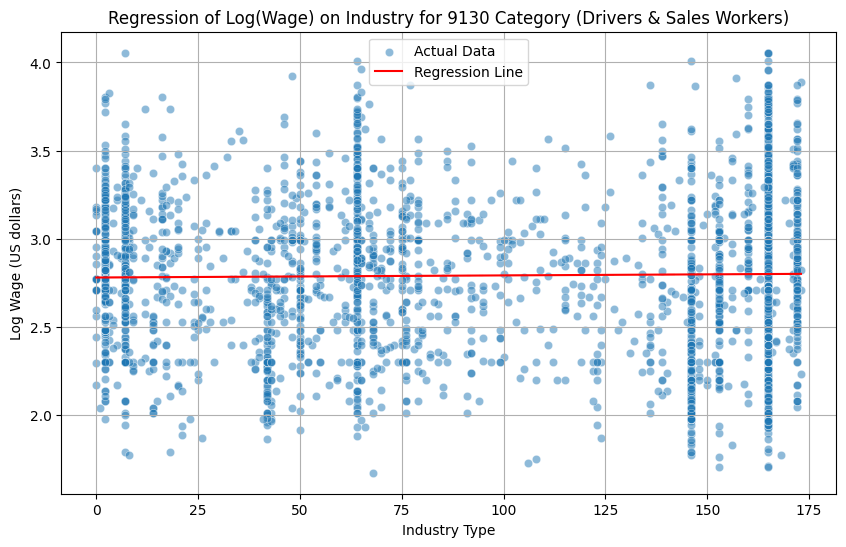

In [27]:
# Define the regression model
model1 = "log_wage ~ ind02"

# Fit the model
result = smf.ols(formula=model1, data=data_9130).fit()

# Generate predictions
data_9130["predicted_log_wage"] = result.predict(data_9130["ind02"])

# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_9130["ind02"], y=data_9130["log_wage"], alpha=0.5, label="Actual Data")
sns.lineplot(x=data_9130["ind02"], y=data_9130["predicted_log_wage"], color="red", label="Regression Line")

# Labels and title
plt.xlabel("Industry Type")
plt.ylabel("Log Wage (US dollars)")
plt.title("Regression of Log(Wage) on Industry for 9130 Category (Drivers & Sales Workers)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


C:\Users\mailb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
C:\Users\mailb\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


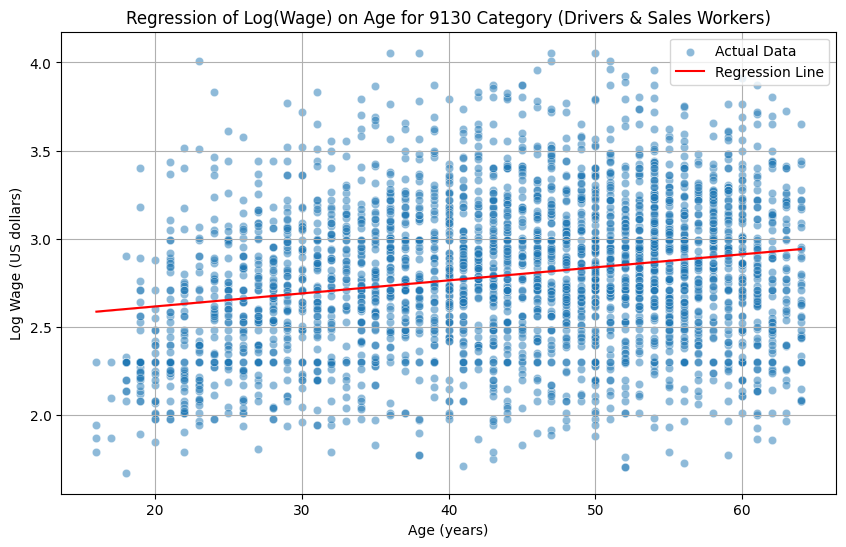

In [28]:
# Define the regression model
model1 = "log_wage ~ age"

# Fit the model
result = smf.ols(formula=model1, data=data_9130).fit()

# Generate predictions
data_9130["predicted_log_wage"] = result.predict(data_9130["age"])

# Create a scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_9130["age"], y=data_9130["log_wage"], alpha=0.5, label="Actual Data")
sns.lineplot(x=data_9130["age"], y=data_9130["predicted_log_wage"], color="red", label="Regression Line")

# Labels and title
plt.xlabel("Age (years)")
plt.ylabel("Log Wage (US dollars)")
plt.title("Regression of Log(Wage) on Age for 9130 Category (Drivers & Sales Workers)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [29]:
# Define a single regression model
model1 = "log_wage ~ age"

# Fit the model
result = smf.ols(formula=model1, data=data_9130).fit()

# Display regression summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     150.3
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           8.93e-34
Time:                        17:01:10   Log-Likelihood:                -1630.7
No. Observations:                3135   AIC:                             3265.
Df Residuals:                    3133   BIC:                             3278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4690      0.027     89.918      0.0

In [30]:
# Define a multi regression models
model2 = "log_wage ~ age + grade92"

# Fit the model
result = smf.ols(formula=model2, data=data_9130).fit()

# Display regression summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     95.79
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           4.17e-41
Time:                        17:01:10   Log-Likelihood:                -1611.1
No. Observations:                3135   AIC:                             3228.
Df Residuals:                    3132   BIC:                             3246.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2567      0.043     51.967      0.0

In [31]:
model3 = "log_wage ~ age + grade92 + ethnic + marital + ownchild"


# Fit the model
result = smf.ols(formula=model3, data=data_9130).fit()

# Display regression summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     47.64
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           1.24e-47
Time:                        17:01:10   Log-Likelihood:                -1589.2
No. Observations:                3135   AIC:                             3190.
Df Residuals:                    3129   BIC:                             3227.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2896      0.050     45.683      0.0

In [32]:
model4 = "log_wage ~ age + grade92 + marital + ownchild + ind02 + state + ethnic + unionmme"


# Fit the model
result = smf.ols(formula=model4, data=data_9130).fit()

# Display regression summary
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     43.20
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           4.20e-66
Time:                        17:01:10   Log-Likelihood:                -1539.8
No. Observations:                3135   AIC:                             3098.
Df Residuals:                    3126   BIC:                             3152.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.2986      0.052     

## Model Performance Comparison

In [33]:
# Define Final Choice of Models
model_equations = {
    "Model 1": "log_wage ~ age",
    "Model 2": "log_wage ~ age + grade92",
    "Model 3": "log_wage ~ age + grade92 + ethnic + marital + ownchild",
    "Model 4": "log_wage ~ age + grade92 + marital + ownchild + ind02 + state + ethnic + unionmme"
}

# Fit models and compute performance metrics
performance_metrics = {}

for model_name, formula in model_equations.items():
    # Fit model
    model = smf.ols(formula=formula, data=data_9130).fit()
    
    # (a) RMSE on the full sample
    y_true = data_9130["log_wage"]
    y_pred = model.predict(data_9130)
    rmse_full = np.sqrt(mean_squared_error(y_true, y_pred))

    # (b) Cross-validated RMSE using 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_cv = []

    for train_idx, test_idx in kf.split(data_9130):
        train_data, test_data = data_9130.iloc[train_idx], data_9130.iloc[test_idx]
        cv_model = smf.ols(formula=formula, data=train_data).fit()
        y_test_pred = cv_model.predict(test_data)
        y_test_true = test_data["log_wage"]
        rmse_cv.append(np.sqrt(mean_squared_error(y_test_true, y_test_pred)))

    rmse_cv_mean = np.mean(rmse_cv)

    # (c) BIC (Bayesian Information Criterion)
    bic = model.bic

    # Store results
    performance_metrics[model_name] = {
        "RMSE (Full Sample)": rmse_full,
        "Cross-Validated RMSE": rmse_cv_mean,
        "BIC (Full Sample)": bic
    }

# Convert results to DataFrame and display
performance_df = pd.DataFrame(performance_metrics).T

# Print the dataframe
print(performance_df)

         RMSE (Full Sample)  Cross-Validated RMSE  BIC (Full Sample)
Model 1            0.407071              0.406821        3277.571100
Model 2            0.404529              0.404308        3246.349312
Model 3            0.401707              0.402000        3226.603479
Model 4            0.395431              0.395930        3152.026356
